
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

...download...

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import statsmodels as sm
import statsmodels.formula.api as smf
from matplotlib import gridspec
import os
import sys
%matplotlib inline
np.random.seed(2002)

In [2]:
!curl -O 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'
!curl -O 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  14.8M      0 --:--:-- --:--:-- --:--:-- 14.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  2509k      0 --:--:--  0:00:01 --:--:-- 2508k


In [3]:
!mv mn_mappluto_18v1.zip $PUIDATA

In [22]:
os.system("unzip " + os.getenv("PUIDATA") + "/" + "mn_mappluto_18v1.zip")

0

In [19]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gpd.read_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


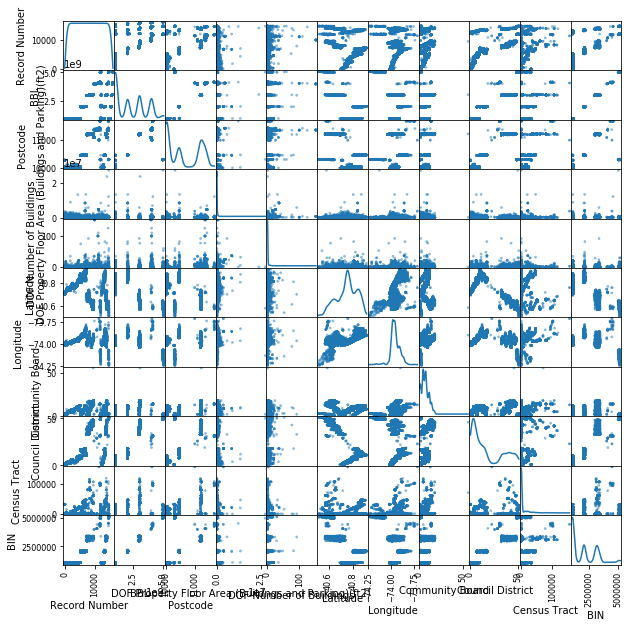

In [23]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde')

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [15]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [ ]:
bsize = bsize[['UnitsRes', 'UnitsTotal', 'YearBuilt', 'BBL', 'geometry']]

In [71]:
nrg = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

In [72]:
bsize.columns.sort_values()

Index([u'BBL', u'UnitsRes', u'UnitsTotal', u'YearBuilt', u'geometry'], dtype='object')

In [73]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [74]:
#leave
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


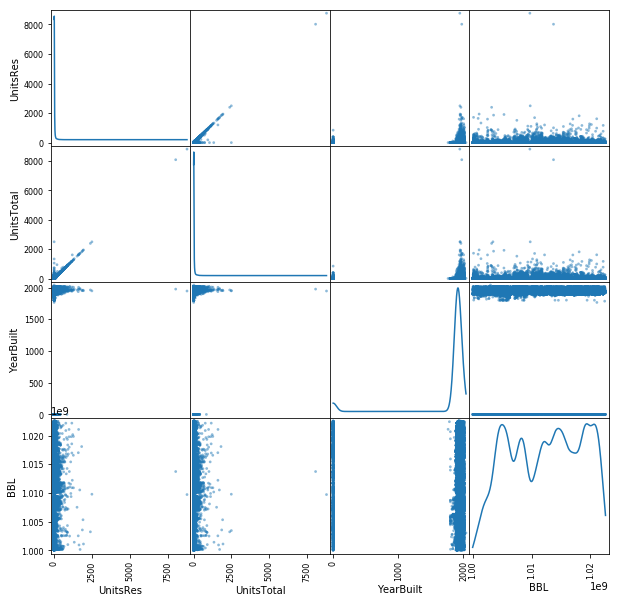

In [175]:
#leave (dont try this scatter matrix before cleaning the data, it will take a while)
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

Figure 2: Scatter plot among different variables of the data. Here we can see the correlation and relationship between the variables. The Total Units and residential units variable show direct positve correlation. The Year built and Units variables show all the points at one corner as most of the buildings were built in that specific period.

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


Converting the string values in the varibles to numeric values for further analysis

In [76]:
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [77]:
bsize['BBL'] = pd.to_numeric(bsize['BBL'])

In [78]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]
#[...] do this for all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#this should not return an error
#notice I can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [79]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

('number of missing energy observations:', 4623)


In [80]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      float(len(nrg['Site EUI(kBtu/ft2)']))))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [81]:
bblnrgdata = pd.merge(nrg, bsize, on='BBL', how='inner')

In [83]:
#leave
#merge in a geodataframe for mapping, and if you want in a regular DF for analysis (more portable)
list = ['Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)', 'UnitsTotal']
bblnrgdata.dropna(subset=list, inplace=True)

In [84]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,..."
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,..."
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ..."
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,..."


In [85]:
type(bblnrgdata)

pandas.core.frame.DataFrame

In [86]:
bblnrgdata.describe()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt
count,5.039000e+03,5.039000e+03,5.039000e+03,5039.000000,5039.000000,5039.000000
mean,1.012012e+09,1.157288e+03,2.144382e+05,99.963088,112.655090,1935.055368
std,5.513629e+06,4.287661e+04,3.248343e+05,256.374053,259.177366,132.043889
min,1.000048e+09,0.000000e+00,1.000000e+03,0.000000,0.000000,0.000000
25%,1.008265e+09,6.590000e+01,7.206400e+04,0.000000,27.000000,1920.000000
50%,1.012370e+09,8.300000e+01,1.160000e+05,55.000000,63.000000,1930.000000
75%,1.015150e+09,1.041000e+02,2.207000e+05,113.000000,123.000000,1965.000000
max,1.022500e+09,3.018493e+06,9.515627e+06,8764.000000,8812.000000,2016.000000


The maximum and minimum values of some variables show outrageous values. Like Total Units show 0 (min) and and 8812 (max), and min EUI/ft is 0 while max is a very large number. These are probably suprious entries which should be removed from the data.

In [87]:
crs = {'init': 'epsg:4326'}
bblnrgdataGPD = gpd.GeoDataFrame(bblnrgdata, crs=crs, geometry='geometry')
type(bblnrgdataGPD)

geopandas.geodataframe.GeoDataFrame

In [88]:
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD.UnitsTotal < 1000)]
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD['Site EUI(kBtu/ft2)'] < 500)]
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD.UnitsTotal > 0)]

In [89]:
bblnrgdataGPD.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,..."
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,..."
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,..."
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ..."
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,..."


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

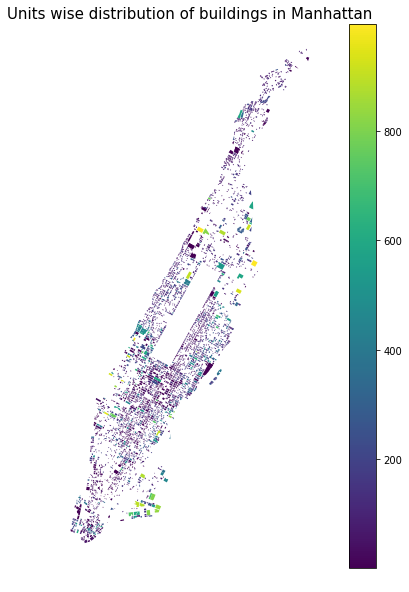

In [177]:
f, ax = plt.subplots(figsize=(10,10))
bblnrgdataGPD.plot(column='UnitsTotal', figsize=(8,8), ax=ax, legend=True)
plt.title('Units wise distribution of buildings in Manhattan', fontsize=15)
ax.set_axis_off()

Here we can see the total number of units of the buildings in Manhattan borough of New York City. The majority of the buildings are of less than 200 units size while some area in Harlem show more than 800 units in buildings. Areas like Upper West Side, Midtown and a small area of Chelsea show some buildings with around 600 units. Buildings in Central park is excluded from the map.

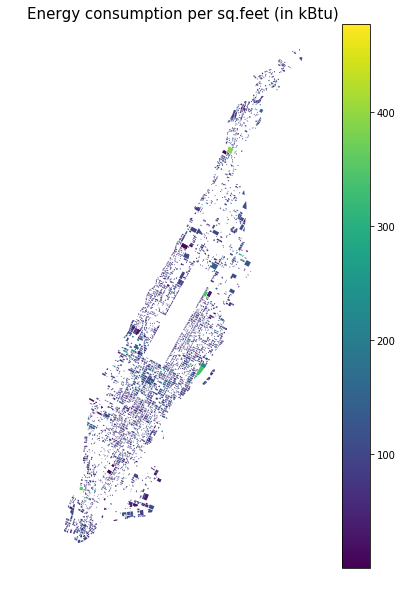

In [178]:
f, ax = plt.subplots(figsize=(10,10))
bblnrgdataGPD.plot(column='Site EUI(kBtu/ft2)', figsize=(8,8), ax=ax, legend=True)
plt.title('Energy consumption per sq.feet (in kBtu)', fontsize=15)
ax.set_axis_off()

Energy consumption of the buildings shown in the previous map is shown here. Majority of the buildings consume less than 100 Btu/sq.feet while a small number of buildings in Upper East Sidr show consumption of more than 400 Btu/sq.ft. Consumption of energy in Central Park buildings is excluded from the analysis.

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [93]:
bblnrgdataGPD['TotalEnergy'] = bblnrgdataGPD['Site EUI(kBtu/ft2)'].astype(float) *\
                    bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
bblnrgdataGPD.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,TotalEnergy
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,...",7272936.4
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ...",42588000.0
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,...",19323877.0


In [94]:
bblnrgdataGPD = bblnrgdataGPD[(bblnrgdataGPD.TotalEnergy > 0)]

Removing entries which show 0 consumption

In [95]:
print "Minimum building energy value: ", bblnrgdataGPD['TotalEnergy'].min()
print "Maximum building energy value: ", bblnrgdataGPD['TotalEnergy'].max()

Minimum building energy value:  5344.0
Maximum building energy value:  1021892512.5


Text(0.5,1,'Energy consumption for different units')

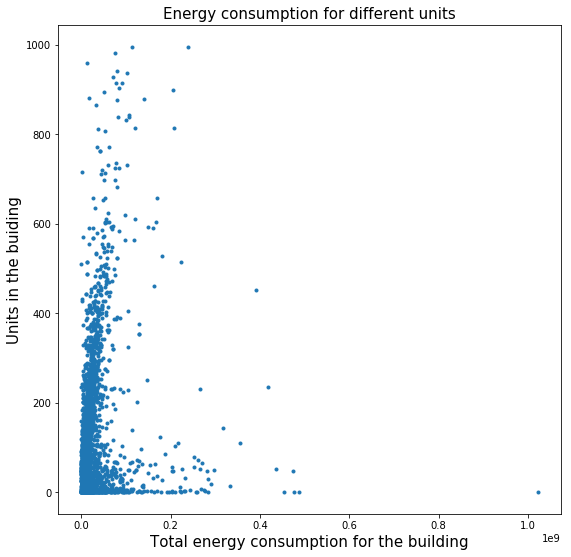

In [96]:
plt.figure(figsize=(9,9))
plt.plot(bblnrgdataGPD['TotalEnergy'], bblnrgdataGPD['UnitsTotal'], '.')
plt.xlabel('Total energy consumption for the building', fontsize=15)
plt.ylabel('Units in the buiding', fontsize=15)
plt.title('Energy consumption for different units', fontsize=15)

Total Energy consumption (kBtu) is plotted as a scatter plot with number of units in the y-axis by multiplying the number of units with the energy consumption per sq.feet. As it was evident from the map, most of the consumption lies in the range of 0-200kBtu/ft. So not surprisingly, we get the plot where most points lie in the right corner of the plot where total energy consumption is less than 0.2e9.

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0,0.5,'$log_{10}$(x)')

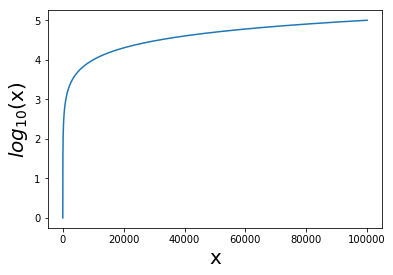

In [30]:
plt.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
plt.xlabel("x", fontsize=20)
plt.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


Text(0.5,1,'Energy consumption for different units')

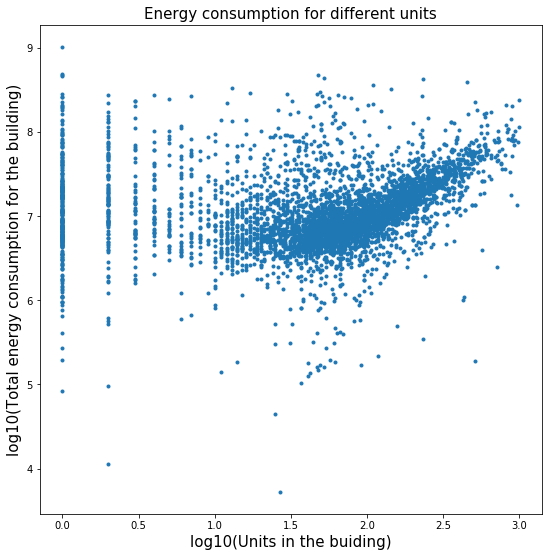

In [140]:
plt.figure(figsize=(9,9))
plt.plot(np.log10(bblnrgdataGPD['UnitsTotal']), np.log10(bblnrgdataGPD['TotalEnergy']), '.')
plt.ylabel('log10(Total energy consumption for the building)', fontsize=15)
plt.xlabel('log10(Units in the buiding)', fontsize=15)
plt.title('Energy consumption for different units', fontsize=15)

Plot of log of the total energy consumed and the number of units in the building. The log scatter plot helps better visualise the data as since there were many data points of energy concentrated in one range, taking log of those helped to visualize better as it grows largely with less value of input.

Text(0.5,1,'Energy consumption for different units')

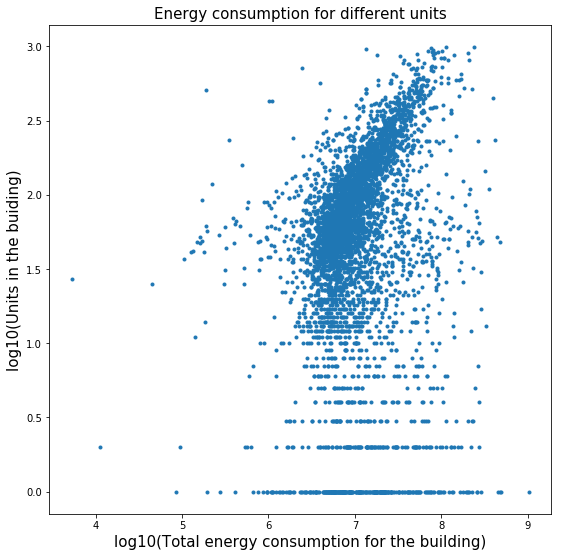

In [141]:
ax = plt.figure(figsize=(9,9))
#ax = fig.add_subplot(2, 1, 1)
plt.plot(np.log10(bblnrgdataGPD['TotalEnergy']), np.log10(bblnrgdataGPD['UnitsTotal']), '.')
plt.xlabel('log10(Total energy consumption for the building)', fontsize=15)
plt.ylabel('log10(Units in the buiding)', fontsize=15)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('Energy consumption for different units', fontsize=15)

Plot of log of the total energy consumed and the number of units in the building. The log scatter plot helps better visualise the data as since there were many data points of energy concentrated in one range, taking log of those helped to visualize better as it grows largely with less value of input.

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

## Model NRG as a linear function of number of units in the building 
Ciertainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**answer**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

In [99]:
bblnrgdataGPD.replace([np.inf, -np.inf], np.nan)
bblnrgdataGPD.dropna(inplace=True)

Dropping the infinite values from the data

In [100]:
bblnrgdataGPD['logEnergy'] = np.log(bblnrgdataGPD['TotalEnergy'])
bblnrgdataGPD['logUnits'] = np.log(bblnrgdataGPD['UnitsTotal'])
bblnrgdataGPD.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,TotalEnergy,logEnergy,logUnits
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0,17.538357,4.025352
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1,18.685969,0.693147
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,...",7272936.4,15.799671,2.079442
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ...",42588000.0,17.567083,4.158883
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,...",19323877.0,16.776852,3.178054


### Units vs Energy

In [102]:
model1 = smf.ols(formula='logUnits ~ logEnergy', data=bblnrgdataGPD).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     140.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           5.75e-32
Time:                        15:00:56   Log-Likelihood:                -8880.0
No. Observations:                4886   AIC:                         1.776e+04
Df Residuals:                    4884   BIC:                         1.778e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1989      0.344     -0.579      0.563      -0.873       0.475
logEnergy      0.2514      0.021     11.852      0.000       0.210       0.293
==============================================================================
Omnibus:                      962.503   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1660.180
Skew:                          -1.290   Prob(JB):                         0.00
Kurtosis:                       4.223   Cond. No.                         262.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model gives a poor R squared value of 0.028 which means it is not able to explain the variance in our data. Also, the 95% interval of the intercept includes 0 which again suggests that the linear model is not a good fit for this data.

Text(0.5,1,'Energy consumption for different units and fitted linear model')

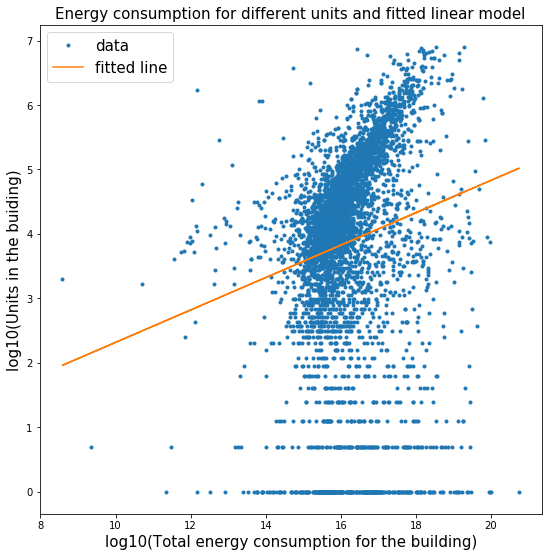

In [148]:
plt.figure(figsize=(9,9))
plt.plot(bblnrgdataGPD['logEnergy'], bblnrgdataGPD['logUnits'], '.', label='data')
plt.plot(bblnrgdataGPD['logEnergy'], model1.predict(bblnrgdataGPD['logEnergy']), label='fitted line')
plt.legend(fontsize=15)
plt.xlabel('log10(Total energy consumption for the building)', fontsize=15)
plt.ylabel('log10(Units in the buiding)', fontsize=15)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('Energy consumption for different units and fitted linear model', fontsize=15)

As seen from the figure, the linear model is not explaining much of the variance in the data.

### Energy against Units

In [153]:
model2 = smf.ols(formula='logEnergy ~ logUnits', data=bblnrgdataGPD).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEnergy   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     140.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           5.75e-32
Time:                        18:59:32   Log-Likelihood:                -6886.3
No. Observations:                4886   AIC:                         1.378e+04
Df Residuals:                    4884   BIC:                         1.379e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.7416      0.039    404.148      0.000      15.665      15.818
logUnits       0.1112      0.009     11.852      0.000       0.093       0.130
==============================================================================
Omnibus:                      438.907   Durbin-Watson:                   1.537
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2552.658
Skew:                           0.207   Prob(JB):                         0.00
Kurtosis:                       6.517   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fitting the linear model on Enegry as dependent and Units as independent variable gives the same R squared value as when we fitted the model on Units as dependent and Energy as independent variable. Again, we conculde that the linear model is not a good model to explain the data.

Text(0.5,1,'Energy consumption for different units and fitted linear model')

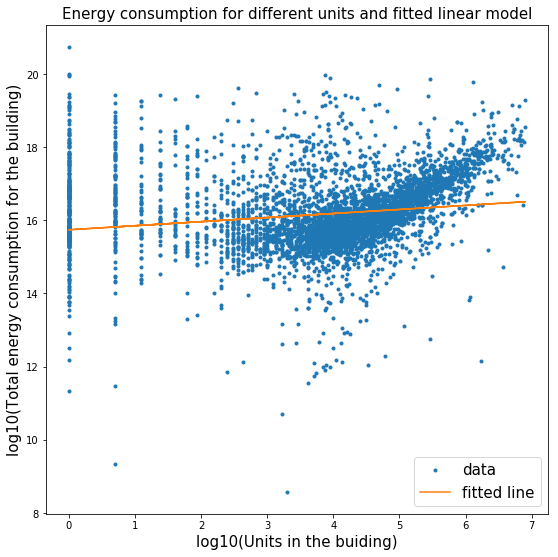

In [154]:
plt.figure(figsize=(9,9))
plt.plot(bblnrgdataGPD['logUnits'], bblnrgdataGPD['logEnergy'], '.', label='data')
plt.plot(bblnrgdataGPD['logUnits'], model2.predict(bblnrgdataGPD['logUnits']), label='fitted line')
plt.legend(fontsize=15)
plt.ylabel('log10(Total energy consumption for the building)', fontsize=15)
plt.xlabel('log10(Units in the buiding)', fontsize=15)
#ax.set_yscale('log')
#ax.set_xscale('log')
plt.title('Energy consumption for different units and fitted linear model', fontsize=15)

As seen from the figure, the linear model is not explaining much of the variance in the data.

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [105]:
bblnrgdataGPD['logUnits2'] = bblnrgdataGPD['logUnits']**2
bblnrgdataGPD.head(2)

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,TotalEnergy,logEnergy,logUnits,logUnits2
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0,17.538357,4.025352,16.203456
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1,18.685969,0.693147,0.480453


Created a column of sqaure of log(Units) values for using in the model.

In [165]:
model2 = smf.ols(formula='logEnergy ~ logUnits + logUnits2', data=bblnrgdataGPD).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEnergy   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     547.6
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          2.80e-215
Time:                        19:09:35   Log-Likelihood:                -6461.3
No. Observations:                4886   AIC:                         1.293e+04
Df Residuals:                    4883   BIC:                         1.295e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.6045      0.046    364.309      0.000      16.515      16.694
logUnits      -0.6977      0.028    -24.998      0.000      -0.752      -0.643
logUnits2      0.1314      0.004     30.463      0.000       0.123       0.140
==============================================================================
Omnibus:                      588.004   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6274.656
Skew:                           0.030   Prob(JB):                         0.00
Kurtosis:                       8.551   Cond. No.                         80.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second degree with Energy as dependent variable and Units and Units squared as independent variables gives a R squared value of 0.183 which suggests that this model is explaining around 18% variance in our data. This is clearly better than the linear model which included one independent variable.

In [158]:
df = bblnrgdataGPD[['logUnits', 'logUnits2']]

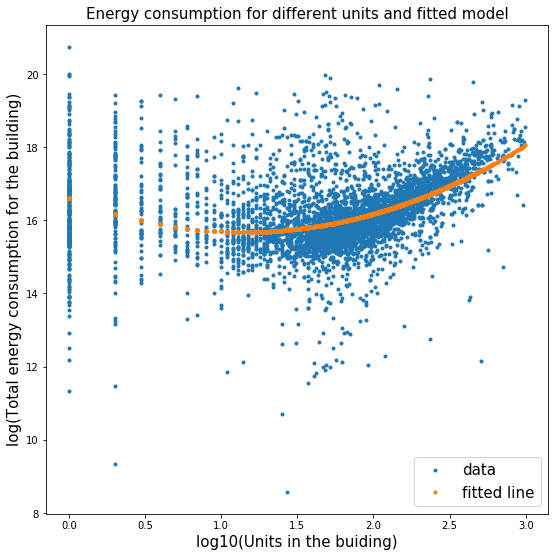

In [172]:
plt.figure(figsize=(9,9))
plt.plot(np.log10(bblnrgdataGPD['UnitsTotal']), bblnrgdataGPD['logEnergy'], '.', label='data')
plt.plot(np.log10(bblnrgdataGPD['UnitsTotal']), model2.predict(df), '.', label='fitted line')
plt.ylabel('log(Total energy consumption for the building)', fontsize=15)
plt.xlabel('log10(Units in the buiding)', fontsize=15)
plt.title('Energy consumption for different units and fitted model', fontsize=15)
plt.legend(fontsize=15)

As seen from the figure, the polynomial fit is much better than the linear fit in explaining our data.

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [179]:
#leave
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    
    '''
    if errors is not None:
        value = (((model-data)**2)/(errors**2)).sum()
    
    else:
        value = 1 - float(((data-data.mean())**2).sum())/float(((model-data)**2).sum())
        
    return value
    

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [109]:
## Assume that there is error in the reported energy. 
## but that is the product of two measured qusntities, each of which will have errors. 
## The minimum error is the squareroot of the value

#errors on the measured quantities
bblnrgdataGPD['LogerrorsEnergy'] = np.sqrt(bblnrgdataGPD['Site EUI(kBtu/ft2)'])/(bblnrgdataGPD['Site EUI(kBtu/ft2)']*np.log(10))

# better WOULD BE to calculate each error and add in quadrature: sqrt(1/A + 1/B) which becomes
#errorsnrg = np.sqrt(1.0 / bblnrgdataCut['Reported Property Floor Area'] + 1.0 / bblnrgdataCut['Site EUI(kBtu/ft2)'])
#but this leads to insane error values (insanely small)

## Assume count statistics in the number of units as well
bblnrgdataGPD['LogerrorsUnits'] = np.sqrt(bblnrgdataGPD['UnitsTotal'])/(bblnrgdataGPD['UnitsTotal']*np.log(10))


Created columns of errors in Energy/sq.ft. and Units in the data

In [50]:
bblnrgdataGPD['TotalEnergyError'] = bblnrgdataGPD['errorsEnergy']*bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft\xc2\xb2)']

In [64]:
bblnrgdataGPD['logEnergyError'] = np.log10(bblnrgdataGPD['logEnergy'])

In [110]:
bblnrgdataGPD.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,TotalEnergy,logEnergy,logUnits,logUnits2,LogerrorsEnergy,LogerrorsUnits
2,1.013110e+09,125.4,330000.0,0,56,1977,"POLYGON ((993141.1744384766 216172.3948364258,...",41382000.0,17.538357,4.025352,16.203456,0.038782,0.058035
10,1.010140e+09,154.9,841709.0,0,2,1999,"POLYGON ((987726.6307983398 214846.9885864258,...",130380724.1,18.685969,0.693147,0.480453,0.034895,0.307093
15,1.007660e+09,122.3,59468.0,0,8,1912,"POLYGON ((984350.5375976562 209226.3930053711,...",7272936.4,15.799671,2.079442,4.324077,0.039271,0.153546
16,1.008150e+09,117.0,364000.0,0,64,1954,"POLYGON ((988118.5700073242 213939.774597168, ...",42588000.0,17.567083,4.158883,17.296309,0.040151,0.054287
18,1.005050e+09,82.1,235370.0,0,24,1926,"POLYGON ((982849.6038208008 203886.2427978516,...",19323877.0,16.776852,3.178054,10.100026,0.047931,0.088650


## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

The largest error bar is for


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),UnitsRes,UnitsTotal,YearBuilt,geometry,TotalEnergy,logEnergy,logUnits,logUnits2,LogerrorsEnergy,LogerrorsUnits
3795,1.019900e+09,0.1,53440.0,27,27,1909,"POLYGON ((994066.3934326172 234073.4490356445,...",5344.0,8.583730,3.295837,10.862541,1.37336,0.083580
4029,1.005350e+09,0.1,113233.0,0,2,1990,"POLYGON ((985466.5781860352 204872.9782104492,...",11323.3,9.334618,0.693147,0.480453,1.37336,0.307093


/anaconda2/lib/python2.7/site-packages/matplotlib/_constrained_layout.py:171: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/anaconda2/lib/python2.7/site-packages/matplotlib/_constrained_layout.py:171: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '
/anaconda2/lib/python2.7/site-packages/matplotlib/_constrained_layout.py:171: UserWarning: There are no gridspecs with layoutboxes. Possibly did not call parent GridSpec with the figure= keyword
  warnings.warn('There are no gridspecs with layoutboxes. '


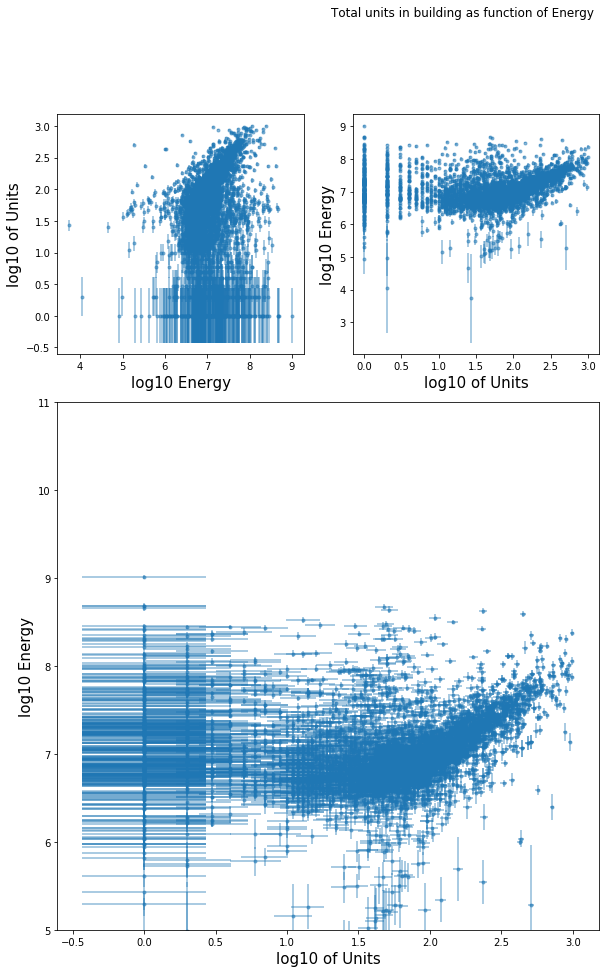

In [116]:
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataGPD.TotalEnergy), np.log10(bblnrgdataGPD.UnitsTotal), 
            yerr=bblnrgdataGPD.LogerrorsUnits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
#plt.xlim(2,11)
#plt.ylim(1,3)
ax1.set_xlabel("log10 Energy", fontsize=15)
plt.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataGPD.UnitsTotal), np.log10(bblnrgdataGPD.TotalEnergy), 
            yerr=bblnrgdataGPD.LogerrorsEnergy, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataGPD.UnitsTotal), np.log10(bblnrgdataGPD.TotalEnergy), 
            yerr=bblnrgdataGPD.LogerrorsEnergy,
           xerr=bblnrgdataGPD.LogerrorsUnits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataGPD[bblnrgdataGPD.LogerrorsEnergy == bblnrgdataGPD.LogerrorsEnergy.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [117]:
len(bblnrgdataGPD)

4886

In [118]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = len(bblnrgdataGPD) - 2
print ("degrees of freedom:" , dof)

('degrees of freedom:', 4884)


In [183]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.UnitsTotal), model1.predict())/float(dof)))

print ("Units vs Energy chi square per DOF w dependent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.UnitsTotal), model1.predict(), 
            errors = bblnrgdataGPD.LogerrorsEnergy) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.UnitsTotal), model1.predict(), 
            errors = np.sqrt(bblnrgdataGPD.LogerrorsEnergy**2 + 
                             bblnrgdataGPD.LogerrorsUnits**2))  / dof))


Units vs Energy residuals (no errors include): 0.00
Units vs Energy chi square per DOF w dependent variable error only: 2689.80
Units vs Energy chi square per DOF : 682.69


In [184]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.TotalEnergy), model2.predict()) / dof))

print ("Energy vs Units chi square per DOF w dependent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.TotalEnergy), model2.predict(), 
            errors = bblnrgdataGPD.LogerrorsEnergy) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataGPD.TotalEnergy), model2.predict(), 
            errors = np.sqrt(bblnrgdataGPD.LogerrorsEnergy**2 + 
                             bblnrgdataGPD.LogerrorsUnits**2))  / dof))


Energy vs Units residuals (no errors include): 0.00
Energy vs Units chi square per DOF w dependent variable error only: 38342.87
Energy vs Units chi square per DOF : 15691.02


### Compare the models using the  chi square:
The chi square statistics for the model with two independent variables (polynomial) is higher as compared to the model with one independent variable (linear) which suggests that the complex model is performing better in explaining the data. When we include the errors for the independent variables, the chi-sq statistic for both the models decrease as compared to when we just consider the error for the dependent variable. This could be because of the larger uncertainities in the independent variables. 

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

In [139]:
model2.compare_lr_test(model1)

(4837.4695203495285, 0.0, 1.0)

On performing the LR test, the model 2 (complex) clearly outperforms the simples model with a large LR statistic of 4837 and a p-value of 0. This confirms our previous assesment that the polynomial model was better in explaining the data as compared to the linear model.

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


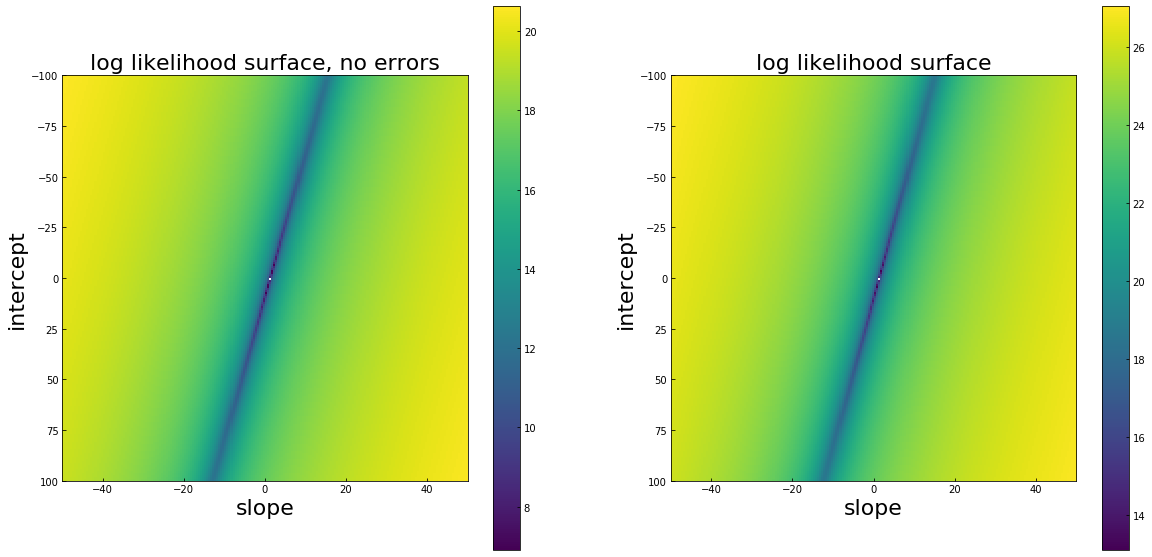

In [124]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


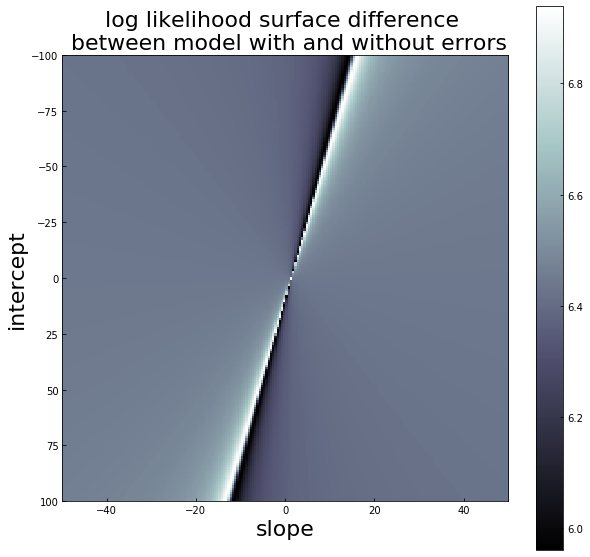

In [125]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

//anaconda/envs/GEOP/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda/envs/GEOP/lib/python3.6/site-packages/pandas/core/generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda/envs/GEOP/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


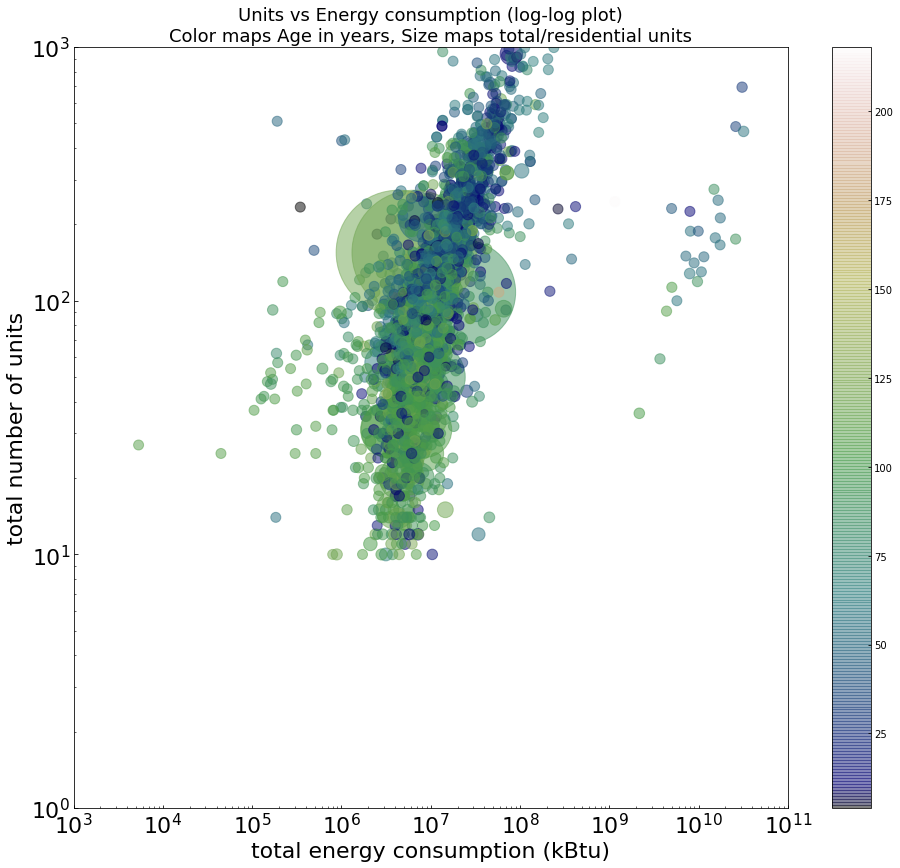

In [126]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units